In [1]:
%matplotlib widget

In [2]:
import numpy as np
import scipy
from sklearn.neighbors import KDTree
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numba import njit

# Define the ellipsoid parameters a >= b >= c
#### length_unit= um ###
r_v_base= 0.5 # allowed range = [0.1, 0.5], volume equivalent radius of base ellipsoid
bc_ratio= 1  # allowed range = [1.0, 5], b/c ratio of base ellipsoid
ab_ratio= 1 # allowed range = [1.0, 2.0], a/b ratio of base ellipsoid
beta= 0.3 # standard deviation of GE surface deformation, allowed range= [0, 0.3]
rng= np.random.default_rng(2) # define random number generator with seed

c= np.cbrt(r_v_base**3/(ab_ratio*bc_ratio**2)) # semiradius of base ellipsoid along z axis

#volume of an ellipsoid V= 4/3*np.pi*a*b*c

lf= (1/100)*np.sqrt(c/0.05) # [um] grid point interval of the cuboid lattice = 0.02um
distance_factor= 3**0.5/2*np.cbrt(bc_ratio*ab_ratio*(c/0.05))

c


np.float64(0.5)

In [3]:
def compute_r_points_on_GaussianEllipsoid(c, bc_ratio, ab_ratio, beta, rng):
    '''
    #### input  ####
    c: semiradius of base ellipsoid along z axis (z-axis coincide with beam propagation direction in laboratory coordinate in default particle orientation)
    bc_ratio: b to c ratio, where b is semiradius of base ellipsoid along y axis
    ab_ratio: a to b ratio, where a is semiradius of base ellipsoid along x axis
    beta: standard deviation of the Gaussian ellipsoid

    ### output ###
    r_points_on_GE_surf: r samples on the computed GE surface, 2d numpy array with shape (N,3), each row is the 3 cartesian components (x,y,z) of each sample, N= N_theta*N_phi*surface_interpolation_factor**2
    x: meshgrid data of x coordinate as a function of (theta,phi), 2d numpy array with shape=(N_phi*surface_interpolation_factor, N_theta*surface_interpolation_factor)
    y: meshgrid data of y coordinate as a function of (theta,phi), 2d numpy array with shape=(N_phi*surface_interpolation_factor, N_theta*surface_interpolation_factor)
    z: meshgrid data of z coordinate as a function of (theta,phi), 2d numpy array with shape=(N_phi*surface_interpolation_factor, N_theta*surface_interpolation_factor)

    '''
    
    
    b= c*bc_ratio
    a= b*ab_ratio
    h0=c**2/a # minium radius of curvature

    lc= c*0.3 # correlation length (fixed to c*0.3)

    # Generate grid points of polar coordinates (theta, phi)
    N_theta= 25
    N_phi= 100
    theta = np.linspace(0, np.pi, N_theta)
    phi = np.linspace(0, 2*np.pi, N_phi)

    theta_mesh, phi_mesh = np.meshgrid(theta, phi, indexing='ij')

    # Cartesian coorinates x0(theta,phi), y0(theta,phi), z0(theta,phi) on the surface of the base ellipsold (x/a)**2 + (y/b)**2 + (z/c)**2 =1
    x0 = a*np.sin(theta_mesh)*np.cos(phi_mesh)
    y0 = b*np.sin(theta_mesh)*np.sin(phi_mesh)
    z0 = c*np.cos(theta_mesh)

    # index rule: x0[i_theta, i_phi], y0[i_theta, i_phi], z0[i_theta, i_phi]

    @njit
    def compute_s_vec_cov_matrix(x0,y0,z0,lc,beta,N_theta,N_phi):
        N= N_theta*N_phi # total number of surface grid points
        
        s_vec_cov_matrix= np.zeros((N,N))
        #index = i_theta*N_phi + i_phi
        for i_dim0 in range(N):
            #if i_dim0 % 100 == 0:
                #print("i_dim0/N= {:.1f} % processed".format(i_dim0/N*100))
            i_theta_dim0= int(i_dim0 // N_phi)
            i_phi_dim0= int(i_dim0 -i_theta_dim0*N_phi)
            for i_dim1 in range(N):
                i_theta_dim1= int(i_dim1 // N_phi)
                i_phi_dim1= int(i_dim1 -i_theta_dim1*N_phi)
                
                d2= (x0[i_theta_dim0,i_phi_dim0]-x0[i_theta_dim1,i_phi_dim1])**2 + (y0[i_theta_dim0,i_phi_dim0]-y0[i_theta_dim1,i_phi_dim1])**2 + (z0[i_theta_dim0,i_phi_dim0]-z0[i_theta_dim1,i_phi_dim1])**2
                Cs= np.exp(-0.5*d2/lc**2)
                s_vec_cov_matrix[i_dim0,i_dim1]= beta**2*Cs
        
        #s_vec_cov_matrix= s_vec_cov_matrix + np.transpose(s_vec_cov_matrix)
        return s_vec_cov_matrix
    
    
    s_vec_cov_matrix= compute_s_vec_cov_matrix(x0,y0,z0,lc,beta,N_theta,N_phi)
    s_vec_mean= np.zeros(N_theta*N_phi)

    s_samples= rng.multivariate_normal(s_vec_mean, s_vec_cov_matrix, size=1, method='eigh').squeeze()
    

    s= np.zeros_like(x0) 
    for i_theta in range(N_theta):
        for i_phi in range(N_phi):
            index= i_theta*N_phi + i_phi
            s[i_theta,i_phi]= s_samples[index]

    
    # interpolation fnction of s(theta,phi)
    f_interp= scipy.interpolate.RectBivariateSpline(theta,phi,s)


    # multiply the number of grid points of polar coordinates (theta, phi) by the surface_interpolation_factor
    surface_interpolation_factor= int(4*np.cbrt(bc_ratio*ab_ratio))
    theta_new = np.linspace(0, np.pi, surface_interpolation_factor*N_theta)
    phi_new = np.linspace(0, 2*np.pi, surface_interpolation_factor*N_phi)

    theta_new_mesh, phi_new_mesh = np.meshgrid(theta_new, phi_new, indexing='ij')

    s_intp= f_interp(theta_new,phi_new)

    # Cartesian coorinates x0(theta,phi), y0(theta,phi), z0(theta,phi) on the surface of the base ellipsold (x/a)**2 + (y/b)**2 + (z/c)**2 =1
    x0 = a*np.sin(theta_new_mesh)*np.cos(phi_new_mesh)
    y0 = b*np.sin(theta_new_mesh)*np.sin(phi_new_mesh)
    z0 = c*np.cos(theta_new_mesh)

    n0_vec= np.array([x0/a**2, y0/b**2, z0/c**2])/np.sqrt((x0/a**2)**2 + (y0/b**2)**2 + (z0/c**2)**2) # unit outward normal on the surface point of the base ellipsoid, n0_vec(theta,phi)4

    x_GRE_surf= x0+h0*((np.exp(s_intp)-(1/2)*beta**2)-1)*n0_vec[0,:,:]
    y_GRE_surf= y0+h0*((np.exp(s_intp)-(1/2)*beta**2)-1)*n0_vec[1,:,:]
    z_GRE_surf= z0+h0*((np.exp(s_intp)-(1/2)*beta**2)-1)*n0_vec[2,:,:]

    x_flat= x_GRE_surf.flatten().squeeze()
    y_flat= y_GRE_surf.flatten().squeeze()
    z_flat= z_GRE_surf.flatten().squeeze()

    r_points_on_GE_surf=  np.column_stack((x_flat,y_flat,z_flat)) # (N,3) numpy array

    return r_points_on_GE_surf, x_GRE_surf, y_GRE_surf, z_GRE_surf

In [4]:
r_points_on_GE_surf, x_GRE_surf, y_GRE_surf, z_GRE_surf= compute_r_points_on_GaussianEllipsoid(c, bc_ratio, ab_ratio, beta, rng)

In [5]:
def create_cuboid_lattice_that_encloses_GE_shape(r_points_on_GE_surf):

    x_range_max= np.max(np.abs(r_points_on_GE_surf[:,0]))
    y_range_max= np.max(np.abs(r_points_on_GE_surf[:,1]))
    z_range_max= np.max(np.abs(r_points_on_GE_surf[:,2]))

    lattice_x_range= x_range_max+lf
    lattice_y_range= y_range_max+lf
    lattice_z_range= z_range_max+lf

    x_grid, y_grid, z_grid = np.meshgrid(np.arange(-lattice_x_range,lattice_x_range, lf),np.arange(-lattice_y_range,lattice_y_range, lf),np.arange(-lattice_z_range,lattice_z_range, lf), indexing='ij')
    lattice_grid_points= np.column_stack((x_grid.ravel(),y_grid.ravel(),z_grid.ravel())) # (N,3) numpy array
    
    n_x= len(np.arange(-lattice_x_range,lattice_x_range, lf))
    n_y= len(np.arange(-lattice_y_range,lattice_y_range, lf))
    n_z= len(np.arange(-lattice_z_range,lattice_z_range, lf))

    lattice_n= np.array([n_x,n_y,n_z], dtype=int) # number of grid points along (x,y,z) axes
    
    # lattice_address = ix*n[1]*n[2]+iy*n[2]+iz, where ix=0,...,n[0] ; iy=0,...,n[1] ; iz=0,...,n[2]

    lattice_domain= ([-lattice_x_range, lattice_x_range], [-lattice_y_range, lattice_y_range], [-lattice_z_range, lattice_z_range]) 

    return lattice_domain, lattice_n, lattice_grid_points

In [6]:
lattice_domain, lattice_n, lattice_grid_points= create_cuboid_lattice_that_encloses_GE_shape(r_points_on_GE_surf)

lattice_domain, lattice_n

(([np.float64(-0.7703587798516078), np.float64(0.7703587798516078)],
  [np.float64(-0.8738716411245667), np.float64(0.8738716411245667)],
  [np.float64(-0.8841051350762016), np.float64(0.8841051350762016)]),
 array([49, 56, 56]))

In [7]:
# KDTree for the points cloud distributed over the surface of Gaussian Ellipsoid
tree = KDTree(r_points_on_GE_surf)
query_point = lattice_grid_points # この点から最も近い点を探す
dist, ind = tree.query(query_point, k=1)  # k=1 は最も近い1点を求めることを意味する
dist_from_GRE= dist[:,0]
dist_from_GRE

array([0.98004572, 0.96400269, 0.94795532, ..., 0.52832528, 0.54640275,
       0.56567158])

In [8]:
@njit
def is_lattice_address_in_GE_volume(lattice_n, lf, dist_from_GRE):

    '''
    #### input  ####
    lattice_n: number of lattice grid points of cuboid along x, y, z axes, 1d numpy array of size 3
    lf: grid point interval of the cuboid lattice in um
    dist_from_GRE: distance from the closest sample point on the GE surface, 1d numpy array of size N, where N= n[0]*n[1]*n[2] is the total number of grid points in the cuboid lattice 
    

    ### output ###
    lattice_grid_points_is_in_GEvol: logical flag of each lattice address that is True if inside the GE volume, 1d numpy array with size= N= n[0]*n[1]*n[2], dtype=bool.

    '''
    # mask along z
    lattice_grid_points_is_in_GEvol_along_z= np.full(np.prod(lattice_n), False, dtype=bool)
    for ix in range(lattice_n[0]):
        for iy in range(lattice_n[1]):
            lattice_address_xy= ix*lattice_n[1]*lattice_n[2]+iy*lattice_n[2]
            is_in_vol_along_z= np.full((2,lattice_n[2]),False,dtype=bool)
            for iter in range(2):
                crossed_1st_boundary= False
                
                if iter == 0:
                    for iz in range(0,lattice_n[2],1):
                        lattice_address= ix*lattice_n[1]*lattice_n[2]+iy*lattice_n[2]+iz
                        if (dist_from_GRE[lattice_address] < distance_factor*lf) and (crossed_1st_boundary == False) :
                            crossed_1st_boundary= True
                            continue
                        if crossed_1st_boundary == True:
                            is_in_vol_along_z[iter,iz]= True
                if iter == 1:
                    for iz in range(lattice_n[2]-1,-1,-1):
                        lattice_address= ix*lattice_n[1]*lattice_n[2]+iy*lattice_n[2]+iz
                        if (dist_from_GRE[lattice_address] < distance_factor*lf) and (crossed_1st_boundary == False) :
                            crossed_1st_boundary= True
                            continue
                        if crossed_1st_boundary == True:
                            is_in_vol_along_z[iter,iz]= True

            lattice_grid_points_is_in_GEvol_along_z[lattice_address_xy:lattice_address_xy+lattice_n[2]:1] = is_in_vol_along_z[0,:]*is_in_vol_along_z[1,:]


    # mask along y
    lattice_grid_points_is_in_GEvol_along_y= np.full(np.prod(lattice_n), False, dtype=bool)
    for iz in range(lattice_n[2]):
        for ix in range(lattice_n[0]):
            lattice_address_zx= ix*lattice_n[1]*lattice_n[2]+iz
            is_in_vol_along_y= np.full((2,lattice_n[1]),False,dtype=bool)
            for iter in range(2):
                crossed_1st_boundary= False
                
                if iter == 0:
                    for iy in range(0,lattice_n[1],1):
                        lattice_address= ix*lattice_n[1]*lattice_n[2]+iy*lattice_n[2]+iz
                        if (dist_from_GRE[lattice_address] < distance_factor*lf) and (crossed_1st_boundary == False) :
                            crossed_1st_boundary= True
                            continue
                        if crossed_1st_boundary == True:
                            is_in_vol_along_y[iter,iy]= True
                if iter == 1:
                    for iy in range(lattice_n[1]-1,-1,-1):
                        lattice_address= ix*lattice_n[1]*lattice_n[2]+iy*lattice_n[2]+iz
                        if (dist_from_GRE[lattice_address] < distance_factor*lf) and (crossed_1st_boundary == False) :
                            crossed_1st_boundary= True
                            continue
                        if crossed_1st_boundary == True:
                            is_in_vol_along_y[iter,iy]= True

            lattice_grid_points_is_in_GEvol_along_y[lattice_address_zx:lattice_address_zx+lattice_n[1]*lattice_n[2]:lattice_n[2]] = is_in_vol_along_y[0,:]*is_in_vol_along_y[1,:]


    # mask along x
    lattice_grid_points_is_in_GEvol_along_x= np.full(np.prod(lattice_n), False, dtype=bool)
    for iy in range(lattice_n[1]):
        for iz in range(lattice_n[2]):
            lattice_address_yz= iy*lattice_n[2]+iz
            is_in_vol_along_x= np.full((2,lattice_n[0]),False,dtype=bool)
            for iter in range(2):
                crossed_1st_boundary= False
                
                if iter == 0:
                    for ix in range(0,lattice_n[0],1):
                        lattice_address= ix*lattice_n[1]*lattice_n[2]+iy*lattice_n[2]+iz
                        if (dist_from_GRE[lattice_address] < distance_factor*lf) and (crossed_1st_boundary == False) :
                            crossed_1st_boundary= True
                            continue
                        if crossed_1st_boundary == True:
                            is_in_vol_along_x[iter,ix]= True
                if iter == 1:
                    for ix in range(lattice_n[0]-1,-1,-1):
                        lattice_address= ix*lattice_n[1]*lattice_n[2]+iy*lattice_n[2]+iz
                        if (dist_from_GRE[lattice_address] < distance_factor*lf) and (crossed_1st_boundary == False) :
                            crossed_1st_boundary= True
                            continue
                        if crossed_1st_boundary == True:
                            is_in_vol_along_x[iter,ix]= True

            lattice_grid_points_is_in_GEvol_along_x[lattice_address_yz::lattice_n[1]*lattice_n[2]] = is_in_vol_along_x[0,:]*is_in_vol_along_x[1,:]

    lattice_grid_points_is_in_GEvol= np.logical_and(np.logical_and(lattice_grid_points_is_in_GEvol_along_z, lattice_grid_points_is_in_GEvol_along_x), lattice_grid_points_is_in_GEvol_along_y)

    return lattice_grid_points_is_in_GEvol

In [9]:
lattice_grid_points_is_in_GEvol= is_lattice_address_in_GE_volume(lattice_n, lf, dist_from_GRE)
lattice_grid_points_in_GEvol= lattice_grid_points[lattice_grid_points_is_in_GEvol]
#22.7s without njit


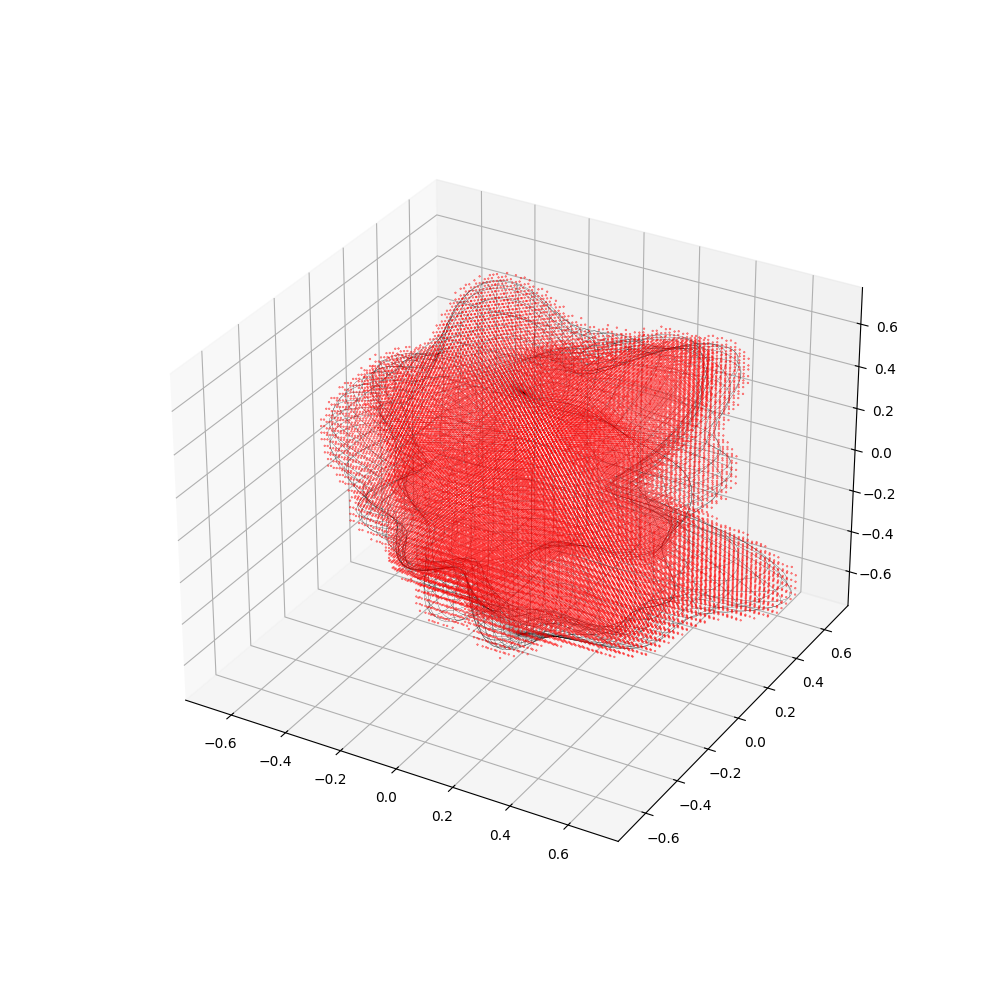

In [10]:
fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(111, projection='3d')

ax.plot_wireframe(x_GRE_surf,y_GRE_surf,z_GRE_surf, color='k', linewidth= 0.2, alpha=0.8)
ax.scatter(lattice_grid_points_in_GEvol[:,0], lattice_grid_points_in_GEvol[:,1], lattice_grid_points_in_GEvol[:,2], marker='x' , s=0.5, color='r', alpha=0.5)

ax.set_xlim(lattice_domain[0])
ax.set_ylim(lattice_domain[0])
ax.set_zlim(lattice_domain[0])

plt.show()

In [11]:
num_total_elements= len(lattice_grid_points_in_GEvol)
np.sum(num_total_elements)

np.int64(33347)

In [12]:
vol= np.sum(num_total_elements)*lf**3
vol

np.float64(1.05452473133635)

In [13]:
r_v= np.cbrt(3*vol/(4*np.pi))
r_v

np.float64(0.6314263770913537)

In [14]:
x_grid, y_grid, z_grid = np.meshgrid( np.arange(0,3,1), np.arange(4,7,1), np.arange(8,11,1), indexing='ij')
    #z_grid, y_grid, x_grid = np.meshgrid(np.arange(-lattice_z_range,lattice_z_range, lf),np.arange(-lattice_y_range,lattice_y_range, lf),np.arange(-lattice_x_range,lattice_x_range, lf))
lattice_grid_points= np.column_stack((x_grid.ravel(),y_grid.ravel(),z_grid.ravel())) 

In [15]:
x_grid.ravel()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2])

In [16]:
y_grid.ravel()

array([4, 4, 4, 5, 5, 5, 6, 6, 6, 4, 4, 4, 5, 5, 5, 6, 6, 6, 4, 4, 4, 5,
       5, 5, 6, 6, 6])

In [17]:
z_grid.ravel()

array([ 8,  9, 10,  8,  9, 10,  8,  9, 10,  8,  9, 10,  8,  9, 10,  8,  9,
       10,  8,  9, 10,  8,  9, 10,  8,  9, 10])

In [18]:
lattice_grid_points

array([[ 0,  4,  8],
       [ 0,  4,  9],
       [ 0,  4, 10],
       [ 0,  5,  8],
       [ 0,  5,  9],
       [ 0,  5, 10],
       [ 0,  6,  8],
       [ 0,  6,  9],
       [ 0,  6, 10],
       [ 1,  4,  8],
       [ 1,  4,  9],
       [ 1,  4, 10],
       [ 1,  5,  8],
       [ 1,  5,  9],
       [ 1,  5, 10],
       [ 1,  6,  8],
       [ 1,  6,  9],
       [ 1,  6, 10],
       [ 2,  4,  8],
       [ 2,  4,  9],
       [ 2,  4, 10],
       [ 2,  5,  8],
       [ 2,  5,  9],
       [ 2,  5, 10],
       [ 2,  6,  8],
       [ 2,  6,  9],
       [ 2,  6, 10]])